<a href="https://colab.research.google.com/github/k228597/lstm/blob/main/Jeju_island_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from function_model import series_to_supervised

In [ ]:
df = pd.read_csv("/content/jeju1.csv", index_col=0, parse_dates=True, dayfirst=True)
df.index.freq = 'D'

In [ ]:
print(df.columns)
columns = ['Rf_BU', 'DtG_P24', 'DtG_P25', 'T_BU', 'T_Pe', 'V_Pe', 'H_FCP']
columns_dict = {'Rf_BU' : 'Rainfall - \n JH gyorae1 \n [mm]', 'DtG_P24' : 'Depth to \n Groundwater \n (P24) [m]', 'DtG_P25' : 'Depth to \n Groundwater \n (P25) [m]',
                'T_BU' : 'Temperature - \n JH gyorae1 \n [mm]', 'T_Pe' : 'Temperature - \n Petrignano [mm]', 'V_Pe' : 'Drainage [m3]', 'H_FCP' : 'Hydrometry [m]'}
df.columns = columns

Index(['Rainfall_JH gyorae1', 'Depth_to_JH gyorae1', 'Depth_to_JH gyorae1.1',
       'Temperature_JH gyorae1', 'Temperature_JH gyorae1.1',
       'Volume_C10_JH gyorae1', 'Hydrometry_Fiume_JH gyorae1'],
      dtype='object')


In [ ]:
df_LSTM = df.copy()

df_LSTM['T_Pe'] = np.where(((df['T_Pe'] == 0) & (df['T_Pe'].shift(1) == 0)) | (df['T_Pe'].diff(-1) > 10) | ((df['T_Pe'] == 0) & (df['T_Pe'].shift(-1) == 0)), np.nan, df['T_Pe'])
df_LSTM['V_Pe'] = np.where(df['V_Pe'] == 0, np.nan, df['V_Pe'])
df_LSTM['H_FCP'] = np.where(df['H_FCP'] == 0, np.nan, df['H_FCP'])
df_LSTM['T_Pe'] = df['T_Pe'].fillna(df['T_BU'])

df_LSTM['V_Pe'] = df_LSTM['V_Pe'].interpolate()
df_LSTM['H_FCP'] = df_LSTM['H_FCP'].interpolate()
df_LSTM['DtG_P25'] = df_LSTM['DtG_P25'].interpolate()
df_LSTM['DtG_P24'] = df_LSTM['DtG_P24'].interpolate()

#col_mean = ['DtG_P25', 'V_Pe', 'H_FCP', 'T_BU']
#col_sum = ['Rf_BU']
#df_LSTM_weekly = df_LSTM[col_mean].resample('W').mean()
#df_LSTM_weekly['Rf_BU'] = df_LSTM[col_sum].resample('W').sum()
cols = ['DtG_P25', 'V_Pe', 'H_FCP', 'T_BU', 'Rf_BU']
df_LSTM = df_LSTM.loc['2009':]
df_LSTM = df_LSTM[cols]


In [ ]:
df_LSTM

,DtG_P25,V_Pe,H_FCP,T_BU,Rf_BU
Date,,,,,
2009-01-01,31.14,24530.688,2.4,5.2,0.0
2009-01-02,31.11,28785.888,2.5,2.3,0.0
2009-01-03,31.07,25766.208,2.4,4.4,0.0
2009-01-04,31.05,27919.296,2.4,0.8,0.0
2009-01-05,31.01,29854.656,2.3,1.9,0.0
...,...,...,...,...,...
2020-06-26,25.07,29930.688,2.5,25.7,0.0
2020-06-27,25.11,31332.960,2.4,26.2,0.0
2020-06-28,25.19,32120.928,2.4,26.9,0.0


In [ ]:
def split_dataset(data):
    # split into standard weeks
    train, test = data[29:-120], data[-120:]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/30))
    test = np.array(np.split(test, len(test)/30))
    return train, test

In [ ]:
# convert history into inputs and outputs
def to_supervised_uni(train, n_input, n_out=30):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
    # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
            # move along one time step
            in_start += 1
    return np.array(X), np.array(y)

In [ ]:
# convert history into inputs and outputs
def to_supervised_multi(train, n_input, n_out=30):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
    # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            #x_input = data[in_start:in_end, 0]
            #x_input = x_input.reshape((len(x_input), 1))
            #X.append(x_input)
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
            # move along one time step
            in_start += 1
    return np.array(X), np.array(y)

In [ ]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [ ]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [ ]:
# train the model
def build_model_uni(train, n_input):
    # prepare data
    train_x, train_y = to_supervised_uni(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [ ]:
# train the model
def build_model_multi(train, n_input):
    # prepare data
    train_x, train_y = to_supervised_multi(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [ ]:
# train the model
def build_model_encdec(train, n_input):
    # prepare data
    train_x, train_y = to_supervised_multi(train, n_input)
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1], 1)
    # define parameters
    verbose, epochs, batch_size = 1, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(25, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(25, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(10, activation='relu')))
    #model.add(Dense(40, activation='relu'))
    #model.add(Dense(n_outputs))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [ ]:
# make a forecast
def forecast_uni(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [ ]:
# make a forecast
def forecast_multi(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next day
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [ ]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model_encdec(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each day
    predictions = list()
    for i in range(len(test)):
        # predict the next day
        yhat_sequence = forecast_multi(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next days
        history.append(test[i, :])
    # evaluate predictions days
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, predictions

In [ ]:
df_LSTM['DtG_P25'].max()-df_LSTM['DtG_P25'].min()

14.61

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df_LSTM)
LSTM_scaled = scaler.transform(df_LSTM)

In [ ]:
# split into train and test
train, test = split_dataset(LSTM_scaled)

In [ ]:
# evaluate model and get scores
n_input = 30
score, scores, predictions = evaluate_model(train, test, n_input)

Epoch 1/20
250/250 [==============================] - 9s 22ms/step - loss: 0.0185
Epoch 2/20
250/250 [==============================] - 6s 23ms/step - loss: 0.0013
Epoch 3/20
250/250 [==============================] - 6s 24ms/step - loss: 8.5419e-04
Epoch 4/20
250/250 [==============================] - 5s 22ms/step - loss: 6.3623e-04
Epoch 5/20
250/250 [==============================] - 6s 26ms/step - loss: 6.0729e-04
Epoch 6/20
250/250 [==============================] - 5s 22ms/step - loss: 5.1031e-04
Epoch 7/20
250/250 [==============================] - 6s 25ms/step - loss: 4.8389e-04
Epoch 8/20
250/250 [==============================] - 5s 21ms/step - loss: 4.3183e-04
Epoch 9/20
250/250 [==============================] - 6s 25ms/step - loss: 4.4428e-04
Epoch 10/20
250/250 [==============================] - 5s 21ms/step - loss: 3.9173e-04
Epoch 11/20
250/250 [==============================] - 6s 25ms/step - loss: 4.0035e-04
Epoch 12/20
250/250 [==============================] - 5s 22

In [ ]:
# summarize scores
summarize_scores('lstm', score, scores)

lstm: [0.015] 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0


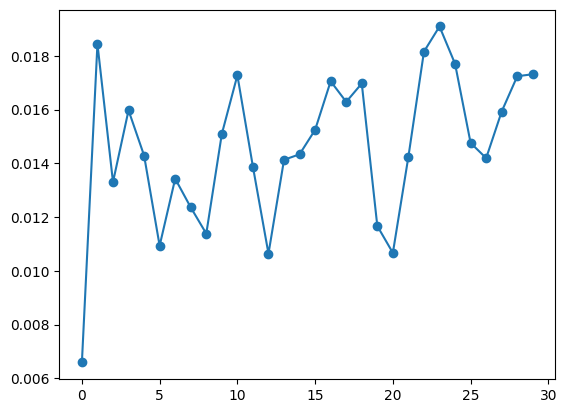

In [ ]:
# plot scores
plt.plot(scores, marker='o', label='lstm')
plt.show()

In [ ]:
m = scaler.data_max_[0] - scaler.data_min_[0]
n = scaler.data_min_[0]

In [ ]:
test_rescaled = test[:, :, 0].reshape(-1) * m + n
predictions_rescaled = predictions.reshape(-1) * m + n

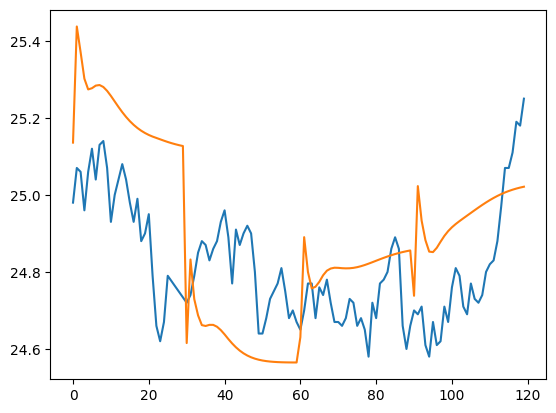

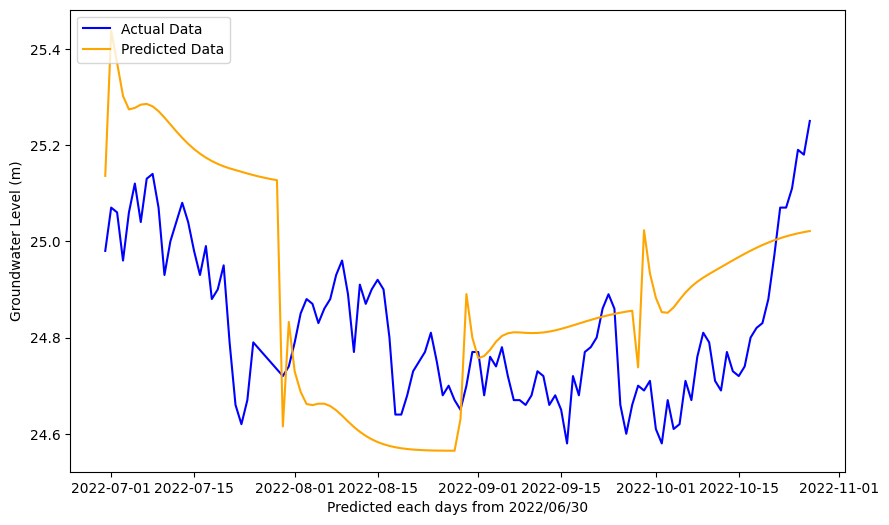

In [ ]:
plt.plot(test_rescaled)
plt.plot(predictions_rescaled )
dates = pd.date_range(start='2022/06/30', periods=len(test_rescaled))

plt.figure(figsize=(10, 6))
plt.plot(dates, test_rescaled, label='Actual Data', color='blue')
plt.plot(dates, predictions_rescaled, label='Predicted Data', color='orange')

plt.xlabel('Predicted each days from 2022/06/30')
plt.ylabel('Groundwater Level (m)')
plt.legend(loc='upper left')  # Add a legend

plt.show()

In [ ]:
RMSE = np.sqrt(np.mean((test_rescaled - predictions_rescaled)**2))

In [ ]:
RMSE

0.2174991975474167